In [ ]:
!pip install -q kaggle
from google.colab import files

# Upload kaggle.json
files.upload()

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d jayaprakashpondy/soil-image-dataset
!unzip -q soil-image-dataset.zip -d soil_dataset


Dataset URL: https://www.kaggle.com/datasets/jayaprakashpondy/soil-image-dataset
License(s): unknown
 90% 129M/144M [00:00<00:00, 1.35GB/s]
100% 144M/144M [00:00<00:00, 1.35GB/s]


In [ ]:
soil_train_dir = "/content/soil_dataset/Dataset/Train"
soil_test_dir = "/content/soil_dataset/Dataset/test"

In [ ]:
# prompt: merge dataset from train and test dataset from sub folders

import os
import pandas as pd

# Define the base directory where the zip was extracted
base_dir = 'soil_dataset'

# Define the paths to the train and test directories
train_dir = soil_train_dir
test_dir = soil_test_dir

# Function to create a DataFrame from image file paths and labels
def create_dataframe(data_dir):
    file_paths = []
    labels = []
    # Iterate through subdirectories (classes)
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            # Iterate through image files in the class directory
            for filename in os.listdir(label_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'): # Add other image extensions if needed
                    file_paths.append(os.path.join(label_dir, filename))
                    labels.append(label)
    return pd.DataFrame({'filepath': file_paths, 'label': labels})

# Create DataFrames for train and test sets
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Merge the train and test DataFrames
merged_df = pd.concat([train_df, test_df], ignore_index=True)

# Display the first few rows of the merged DataFrame
print("Merged DataFrame Head:")
print(merged_df.head())

# Display the shape of the merged DataFrame
print("\nMerged DataFrame Shape:", merged_df.shape)

# Display the value counts of the labels in the merged DataFrame
print("\nLabel Distribution in Merged DataFrame:")
print(merged_df['label'].value_counts())

Merged DataFrame Head:
                                            filepath          label
0  /content/soil_dataset/Dataset/Train/Alluvial s...  Alluvial soil
1  /content/soil_dataset/Dataset/Train/Alluvial s...  Alluvial soil
2  /content/soil_dataset/Dataset/Train/Alluvial s...  Alluvial soil
3  /content/soil_dataset/Dataset/Train/Alluvial s...  Alluvial soil
4  /content/soil_dataset/Dataset/Train/Alluvial s...  Alluvial soil

Merged DataFrame Shape: (1431, 2)

Label Distribution in Merged DataFrame:
label
Alluvial soil    528
Black Soil       340
Red soil         311
Clay soil        252
Name: count, dtype: int64


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
data_dir = 'soil_dataset'
img_size = (224, 224)
batch_size = 32

# Train-validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)


Found 1243 images belonging to 1 classes.
Found 310 images belonging to 1 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load ResNet50 without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 532ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accu

KeyboardInterrupt: 

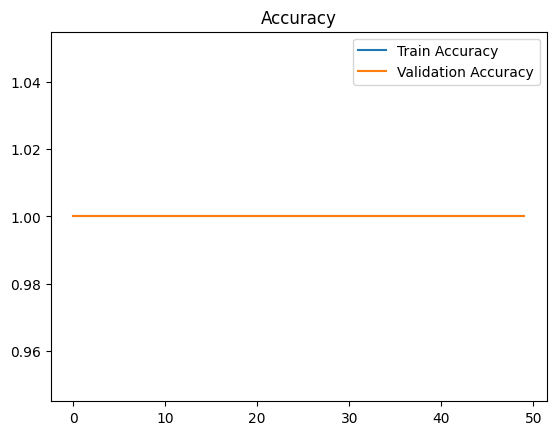

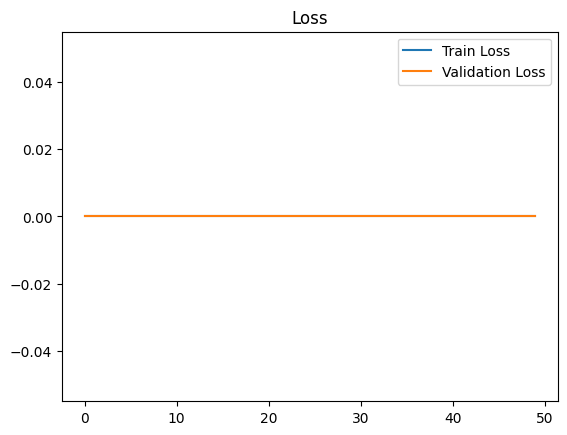

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


Found 1214 images belonging to 4 classes.
Found 339 images belonging to 4 classes.
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 790ms/step - accuracy: 0.4334 - loss: 1.2966 - val_accuracy: 0.2625 - val_loss: 1.3364
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.4747 - loss: 1.1952 - val_accuracy: 0.2743 - val_loss: 1.2355
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.5007 - loss: 1.1626 - val_accuracy: 0.2714 - val_loss: 1.3484
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.4838 - loss: 1.1460 - val_accuracy: 0.2714 - val_loss: 1.3184
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.4920 - loss: 1.1313 - val_accuracy: 0.2684 - val_loss: 1.2923


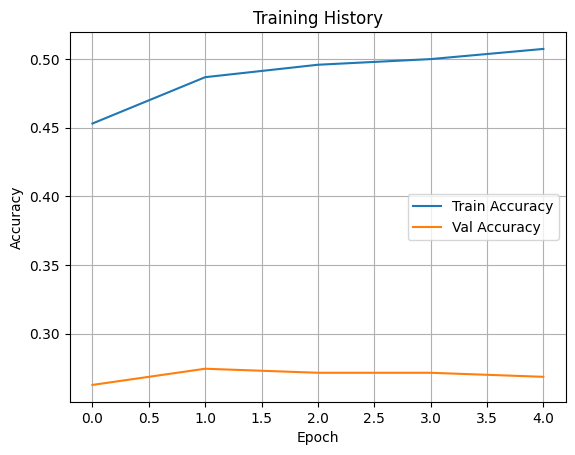

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# === Paths ===
train_dir = "/content/soil_dataset/Dataset/Train"
test_dir = "/content/soil_dataset/Dataset/test"

# === Image size and batch ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# === Data Augmentation and Generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# === Build ResNet50 Model ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Train the model ===
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=test_gen
)

# === Plot training history ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# === Save model ===
model.save("/content/soil_classifier_resnet50.h5")


In [ ]:
# Unfreeze last few layers of ResNet50
base_model.trainable = True

# Optionally freeze first few layers for stability
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
history_finetune = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 882ms/step - accuracy: 0.3369 - loss: 4.0239 - val_accuracy: 0.2743 - val_loss: 1.3714
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.6717 - loss: 0.8562 - val_accuracy: 0.2006 - val_loss: 1.8290
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 506ms/step - accuracy: 0.7258 - loss: 0.7070 - val_accuracy: 0.1917 - val_loss: 2.9243
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.7811 - loss: 0.6008 - val_accuracy: 0.1917 - val_loss: 3.3540
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.8195 - loss: 0.5351 - val_accuracy: 0.1917 - val_loss: 2.8045
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.8015 - loss: 0.5238 - val_accuracy: 0.1917 - val_loss: 2.0799
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 508ms/step - accuracy: 0.8238 - loss: 0.4869 - val_accuracy: 0.2124 - val_loss: 1.5528
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.8680 - loss: 0.3960 - val_accu

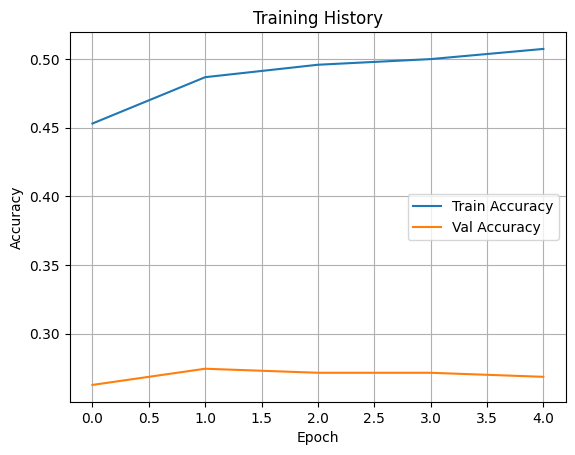

In [ ]:
# === Plot training history ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 1️⃣  Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False          # leave BN frozen too

# 2️⃣  Re-compile (sparse because generators still output ints)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣  Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

# 4️⃣  Fine-tune
history_finetune = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    callbacks=callbacks
)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 864ms/step - accuracy: 0.9609 - loss: 0.1180 - val_accuracy: 0.6254 - val_loss: 1.2788 - learning_rate: 1.0000e-05
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.9399 - loss: 0.1668 - val_accuracy: 0.6578 - val_loss: 1.1124 - learning_rate: 1.0000e-05
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.9559 - loss: 0.1519 - val_accuracy: 0.6106 - val_loss: 1.4656 - learning_rate: 1.0000e-05
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.9554 - loss: 0.1436 - val_accuracy: 0.9292 - val_loss: 0.2076 - learning_rate: 1.0000e-05
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 506ms/step - accuracy: 0.9499 - loss: 0.1678 - val_accuracy: 0.8820 - val_loss: 0.3148 - learning_rate: 1.0000e-05
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.9562 - loss: 0.1213 - val_accuracy: 0.7434 - val_loss: 0.7797 - learning_rate: 1.0000e-05
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accu

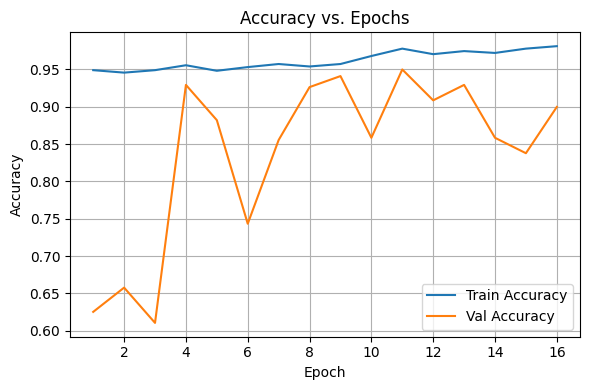

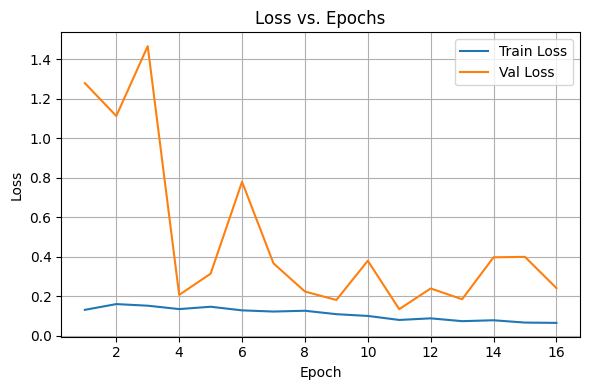

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, metric='accuracy'):
    """Plot train & val curves for a given Keras metric."""
    train_metrics = history.history[metric]
    val_metrics   = history.history[f'val_{metric}']
    epochs        = range(1, len(train_metrics) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_metrics, label=f'Train {metric.title()}')
    plt.plot(epochs, val_metrics,   label=f'Val {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.title(f'{metric.title()} vs. Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Accuracy curve
plot_training_curves(history_finetune, metric='accuracy')

# Loss curve (optional)
plot_training_curves(history_finetune, metric='loss')


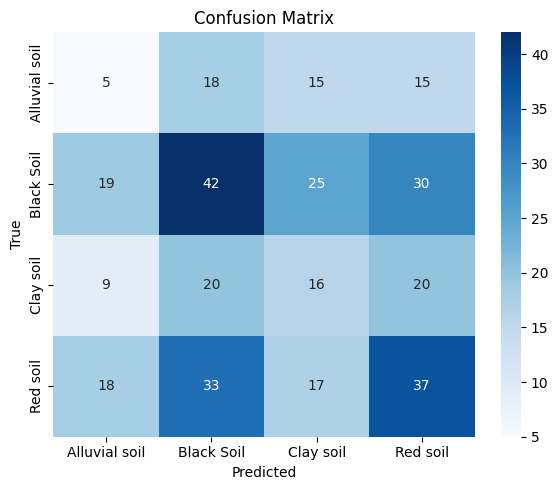

               precision    recall  f1-score   support

Alluvial soil       0.10      0.09      0.10        53
   Black Soil       0.37      0.36      0.37       116
    Clay soil       0.22      0.25      0.23        65
     Red soil       0.36      0.35      0.36       105

     accuracy                           0.29       339
    macro avg       0.26      0.26      0.26       339
 weighted avg       0.30      0.29      0.30       339



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                      # purely for nice heatmap
from sklearn.metrics import confusion_matrix, classification_report

# 🔸 1.  Get true & predicted labels
y_true = test_gen.classes                                         # integer labels
y_pred = model.predict(test_gen, verbose=0).argmax(axis=1)

class_names = list(test_gen.class_indices.keys())                 # ['Alluvial', 'Black', 'Clay', 'Red']

# 🔸 2.  Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 🔸 3.  Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


Found 1214 images belonging to 4 classes.
Found 339 images belonging to 4 classes.
Class weights: {0: np.float64(0.5780952380952381), 1: np.float64(1.331140350877193), 2: np.float64(1.5251256281407035), 3: np.float64(1.1583969465648856)}
Epoch 1/25
38/38 - 83s - 2s/step - accuracy: 0.2100 - loss: 1.4378 - val_accuracy: 0.1917 - val_loss: 1.4397
Epoch 2/25
38/38 - 22s - 571ms/step - accuracy: 0.2488 - loss: 1.4274 - val_accuracy: 0.1917 - val_loss: 1.4223
Epoch 3/25
38/38 - 22s - 577ms/step - accuracy: 0.2504 - loss: 1.4208 - val_accuracy: 0.1917 - val_loss: 1.4050
Epoch 4/25
38/38 - 22s - 571ms/step - accuracy: 0.2504 - loss: 1.4206 - val_accuracy: 0.1917 - val_loss: 1.3969
Epoch 5/25
38/38 - 22s - 570ms/step - accuracy: 0.2471 - loss: 1.4080 - val_accuracy: 0.1858 - val_loss: 1.3884
Epoch 6/25
38/38 - 22s - 568ms/step - accuracy: 0.2586 - loss: 1.4191 - val_accuracy: 0.1534 - val_loss: 1.3891
Epoch 7/25
38/38 - 21s - 565ms/step - accuracy: 0.2142 - loss: 1.4229 - val_accuracy: 0.3422 

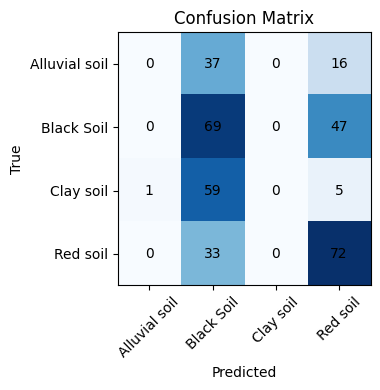

In [ ]:
# ==============================================================
# Soil-Type Classifier  v2.1  –  EfficientNetB0 + One-Cycle LR
# ==============================================================

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np, matplotlib.pyplot as plt, itertools, warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- 1. Paths & basic hyper-params ----------
train_dir = "/content/soil_dataset/Dataset/Train"
val_dir   = "/content/soil_dataset/Dataset/test"

IMG_SIZE     = (224, 224)
BATCH_SIZE   = 32
EPOCHS_HEAD  = 25
EPOCHS_FINE  = 12
MAX_LR       = 1e-4
N_CLASSES    = 4

# ---------- 2. Data generators ----------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=15,
    fill_mode='reflect'
).flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# ---------- 3. Class weights ----------
cw_vals = compute_class_weight('balanced',
                               classes=np.unique(train_gen.classes),
                               y=train_gen.classes)
class_weight = dict(enumerate(cw_vals))
print("Class weights:", class_weight)

# ---------- 4. Build model ----------
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet',
    input_shape=IMG_SIZE + (3,), pooling='avg'
)
base.trainable = False

inputs  = layers.Input(shape=IMG_SIZE + (3,))
x       = base(inputs, training=False)
x       = layers.Dropout(0.5)(x)
outputs = layers.Dense(N_CLASSES, activation='softmax')(x)
model   = models.Model(inputs, outputs)

# ---------- 5. Robust One-Cycle LR callback ----------
class OneCycleLR(tf.keras.callbacks.Callback):
    def __init__(self, max_lr, total_steps, min_lr=1e-5):
        super().__init__()
        self.max_lr, self.total_steps, self.min_lr = max_lr, total_steps, min_lr

    def _set_lr(self, new_lr):
        """Safely set LR whether it's a tf.Variable, tensor, float, or stray str."""
        try:
            lr_ref = self.model.optimizer.learning_rate
        except AttributeError:       # ultra-old TF
            lr_ref = self.model.optimizer.lr

        # If lr_ref is Variable / Tensor → set_value; else → assign directly
        if isinstance(lr_ref, tf.Variable):
            tf.keras.backend.set_value(lr_ref, new_lr)
        else:
            try:
                lr_ref.assign(new_lr)         # tensor?
            except Exception:
                self.model.optimizer.learning_rate = float(new_lr)

    def on_train_batch_begin(self, batch, logs=None):
        step = tf.keras.backend.get_value(self.model.optimizer.iterations)
        pct  = step / self.total_steps
        if pct <= 0.3:
            lr = self.max_lr * pct / 0.3
        else:
            rem = (pct - 0.3) / 0.7
            lr = self.min_lr + 0.5*(self.max_lr - self.min_lr)*(1 + tf.math.cos(np.pi*rem))
        self._set_lr(lr)

steps_per_epoch = int(np.ceil(len(train_gen.classes) / BATCH_SIZE))
onecycle = OneCycleLR(max_lr=MAX_LR, total_steps=steps_per_epoch * EPOCHS_HEAD)

early_stop = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)

# ---------- 6. Compile & train head ----------
model.compile(
    optimizer=tf.keras.optimizers.Adam(MAX_LR),   # **float, not string**
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_head = model.fit(
    train_gen,
    epochs=EPOCHS_HEAD,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[onecycle, early_stop],
    verbose=2
)

# ---------- 7. Fine-tune full backbone ----------
base.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=2
)

# ---------- 8. Evaluate ----------
y_true = val_gen.classes
y_pred = model.predict(val_gen, verbose=0).argmax(axis=1)

print("\n" + classification_report(
    y_true, y_pred, target_names=val_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(N_CLASSES), val_gen.class_indices.keys(), rotation=45)
plt.yticks(range(N_CLASSES), val_gen.class_indices.keys())
for i, j in itertools.product(range(N_CLASSES), range(N_CLASSES)):
    plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout(); plt.show()


In [ ]:
ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    brightness_range=[0.8, 1.2],
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step


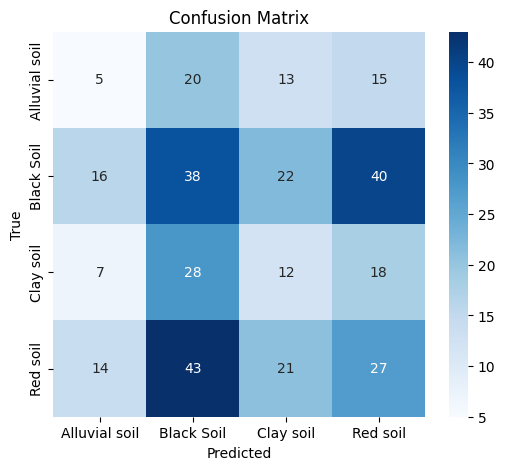

               precision    recall  f1-score   support

Alluvial soil       0.12      0.09      0.11        53
   Black Soil       0.29      0.33      0.31       116
    Clay soil       0.18      0.18      0.18        65
     Red soil       0.27      0.26      0.26       105

     accuracy                           0.24       339
    macro avg       0.22      0.22      0.21       339
 weighted avg       0.24      0.24      0.24       339



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Ground truth
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 840ms/step - accuracy: 0.8428 - loss: 0.4015 - val_accuracy: 0.7670 - val_loss: 0.5495
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.8938 - loss: 0.3179 - val_accuracy: 0.8230 - val_loss: 0.5339
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.9082 - loss: 0.2689 - val_accuracy: 0.6077 - val_loss: 1.3714
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.9162 - loss: 0.2534 - val_accuracy: 0.7699 - val_loss: 0.5864
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 492ms/step - accuracy: 0.9165 - loss: 0.2579 - val_accuracy: 0.4690 - val_loss: 1.4575
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.8906 - loss: 0.2671 - val_accuracy: 0.5900 - val_loss: 0.9506
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.9207 - loss: 0.2352 - val_accuracy: 0.8260 - val_loss: 0.4748
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 496ms/step - accuracy: 0.9118 - loss: 0.2505 - val_accu

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 452ms/step


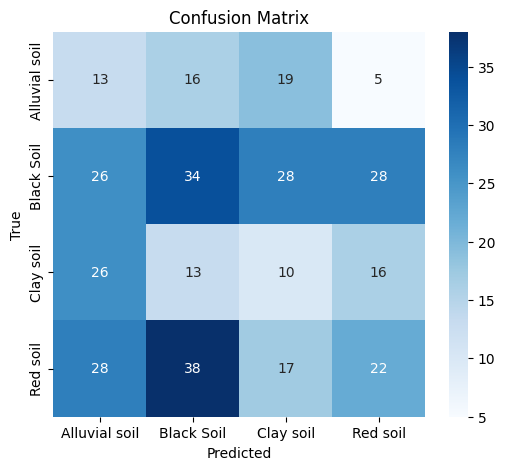

               precision    recall  f1-score   support

Alluvial soil       0.14      0.25      0.18        53
   Black Soil       0.34      0.29      0.31       116
    Clay soil       0.14      0.15      0.14        65
     Red soil       0.31      0.21      0.25       105

     accuracy                           0.23       339
    macro avg       0.23      0.23      0.22       339
 weighted avg       0.26      0.23      0.24       339



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Ground truth
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=50
)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 855ms/step - accuracy: 0.8987 - loss: 0.2403 - val_accuracy: 0.6578 - val_loss: 1.0507
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 499ms/step - accuracy: 0.9357 - loss: 0.2023 - val_accuracy: 0.4838 - val_loss: 1.8127
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.9517 - loss: 0.1787 - val_accuracy: 0.8968 - val_loss: 0.2889
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 509ms/step - accuracy: 0.9349 - loss: 0.1941 - val_accuracy: 0.8732 - val_loss: 0.3264
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.9331 - loss: 0.1894 - val_accuracy: 0.8407 - val_loss: 0.4144
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.9544 - loss: 0.1687 - val_accuracy: 0.7670 - val_loss: 0.7752
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.9209 - loss: 0.1960 - val_accuracy: 0.8968 - val_loss: 0.2716
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.9650 - loss: 0.1306 - val_accu

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step


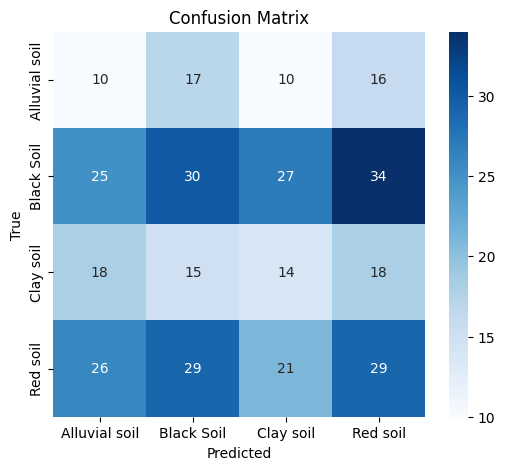

               precision    recall  f1-score   support

Alluvial soil       0.13      0.19      0.15        53
   Black Soil       0.33      0.26      0.29       116
    Clay soil       0.19      0.22      0.20        65
     Red soil       0.30      0.28      0.29       105

     accuracy                           0.24       339
    macro avg       0.24      0.23      0.23       339
 weighted avg       0.26      0.24      0.25       339



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Ground truth
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("best_soil_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=50,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9865 - loss: 0.0507
Epoch 1: val_accuracy improved from -inf to 0.64602, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.9863 - loss: 0.0511 - val_accuracy: 0.6460 - val_loss: 1.0657
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9828 - loss: 0.0599
Epoch 2: val_accuracy improved from 0.64602 to 0.73156, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.9826 - loss: 0.0602 - val_accuracy: 0.7316 - val_loss: 0.9365
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9640 - loss: 0.1072
Epoch 3: val_accuracy improved from 0.73156 to 0.77876, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 531ms/step - accuracy: 0.9642 - loss: 0.1067 - val_accuracy: 0.7788 - val_loss: 0.7585
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9752 - loss: 0.0730
Epoch 4: val_accuracy did not improve from 0.77876
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.9753 - loss: 0.0728 - val_accuracy: 0.7050 - val_loss: 0.9062
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9660 - loss: 0.0851
Epoch 5: val_accuracy improved from 0.77876 to 0.88496, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step - accuracy: 0.9661 - loss: 0.0849 - val_accuracy: 0.8850 - val_loss: 0.3189
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9649 - loss: 0.0743
Epoch 6: val_accuracy did not improve from 0.88496
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.9651 - loss: 0.0742 - val_accuracy: 0.7434 - val_loss: 0.9787
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9794 - loss: 0.0592
Epoch 7: val_accuracy improved from 0.88496 to 0.89086, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - accuracy: 0.9793 - loss: 0.0595 - val_accuracy: 0.8909 - val_loss: 0.2838
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9812 - loss: 0.0632
Epoch 8: val_accuracy did not improve from 0.89086
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 505ms/step - accuracy: 0.9812 - loss: 0.0633 - val_accuracy: 0.5929 - val_loss: 1.6484
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9772 - loss: 0.0604
Epoch 9: val_accuracy improved from 0.89086 to 0.89676, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.9772 - loss: 0.0603 - val_accuracy: 0.8968 - val_loss: 0.2431
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9723 - loss: 0.0759
Epoch 10: val_accuracy improved from 0.89676 to 0.92035, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step - accuracy: 0.9720 - loss: 0.0763 - val_accuracy: 0.9204 - val_loss: 0.1867
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9823 - loss: 0.0635
Epoch 11: val_accuracy did not improve from 0.92035
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.9821 - loss: 0.0639 - val_accuracy: 0.8496 - val_loss: 0.4602
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9751 - loss: 0.0600
Epoch 12: val_accuracy did not improve from 0.92035
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.9750 - loss: 0.0603 - val_accuracy: 0.8378 - val_loss: 0.4458
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9884 - loss: 0.0534
Epoch 13: val_accuracy did not improve from 0.92035
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.9882 - loss: 0.0535 - val_accuracy: 0.8053 - val_loss: 0.7058
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9764 - loss: 0.0605
Epoch 14: val_accuracy d

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 528ms/step - accuracy: 0.9828 - loss: 0.0554 - val_accuracy: 0.9322 - val_loss: 0.1958
Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9707 - loss: 0.0707
Epoch 16: val_accuracy improved from 0.93215 to 0.94100, saving model to best_soil_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 528ms/step - accuracy: 0.9709 - loss: 0.0707 - val_accuracy: 0.9410 - val_loss: 0.1649
Epoch 17/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9799 - loss: 0.0562
Epoch 17: val_accuracy did not improve from 0.94100
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.9799 - loss: 0.0561 - val_accuracy: 0.6814 - val_loss: 1.6776
Epoch 18/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9808 - loss: 0.0650
Epoch 18: val_accuracy did not improve from 0.94100
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.9806 - loss: 0.0651 - val_accuracy: 0.8053 - val_loss: 0.5737
Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9730 - loss: 0.0649
Epoch 19: val_accuracy did not improve from 0.94100
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.9730 - loss: 0.0649 - val_accuracy: 0.7847 - val_loss: 0.6143
Epoch 20/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9812 - loss: 0.0702
Epoch 20: val_accuracy d

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step - accuracy: 0.9770 - loss: 0.0560 - val_accuracy: 0.9617 - val_loss: 0.1166
Epoch 22/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9761 - loss: 0.0660
Epoch 22: val_accuracy did not improve from 0.96165
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.9761 - loss: 0.0661 - val_accuracy: 0.7552 - val_loss: 1.0373
Epoch 23/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9803 - loss: 0.0611
Epoch 23: val_accuracy did not improve from 0.96165
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.9803 - loss: 0.0611 - val_accuracy: 0.7257 - val_loss: 0.8643
Epoch 24/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9804 - loss: 0.0590
Epoch 24: val_accuracy did not improve from 0.96165
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 496ms/step - accuracy: 0.9803 - loss: 0.0593 - val_accuracy: 0.8407 - val_loss: 0.3872
Epoch 25/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9829 - loss: 0.0570
Epoch 25: val_accuracy d

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("best_soil_model.h5")

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step


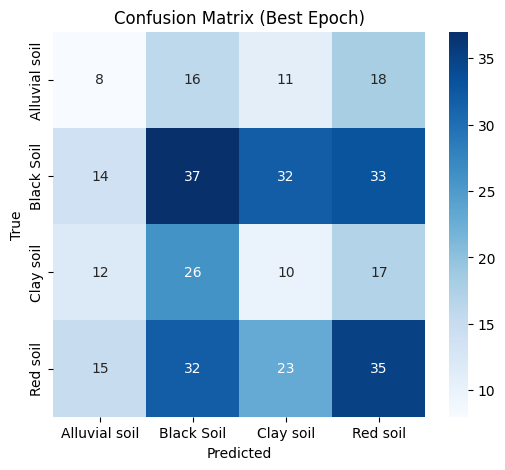

               precision    recall  f1-score   support

Alluvial soil       0.16      0.15      0.16        53
   Black Soil       0.33      0.32      0.33       116
    Clay soil       0.13      0.15      0.14        65
     Red soil       0.34      0.33      0.34       105

     accuracy                           0.27       339
    macro avg       0.24      0.24      0.24       339
 weighted avg       0.27      0.27      0.27       339



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Best Epoch)")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
from tensorflow.keras.models import load_model

# Load best checkpoint
model = load_model("best_soil_model.h5")

# Evaluate again
loss, acc = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {acc:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 0.9614 - loss: 0.1124
✅ Final Test Accuracy: 0.9617


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

In [ ]:
# === Define soil class labels (same order as training generator) ===
class_labels = list(test_gen.class_indices.keys())  # ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']

# === Define prediction function ===
def predict_soil(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array, verbose=0)
    predicted_class = class_labels[np.argmax(pred)]
    confidence = float(np.max(pred))
    return predicted_class, confidence

# === Scan directory and predict for each image ===
image_dir = "/content/drive/MyDrive/crop_and_weed/images"
results = []

for fname in os.listdir(image_dir):
    if fname.lower().endswith(".jpg"):
        img_path = os.path.join(image_dir, fname)
        label, conf = predict_soil(img_path)
        results.append({
            "filename": fname,
            "predicted_soil": label,
            "confidence": conf
        })
        print(f"{fname}: {label} ({conf:.2%})")

# === Optional: Save results to CSV ===
results_df = pd.DataFrame(results)
results_df.to_csv("soil_predictions_cropandweed.csv", index=False)
print("✅ Saved predictions to 'soil_predictions_cropandweed.csv'")

['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
vwg-1237-0015.jpg: Clay soil (91.85%)
vwg-1237-0014.jpg: Alluvial soil (56.88%)
vwg-1237-0012.jpg: Clay soil (97.49%)
vwg-1237-0016.jpg: Clay soil (99.77%)
vwg-1238-0002.jpg: Alluvial soil (53.61%)
vwg-1238-0003.jpg: Clay soil (99.75%)
vwg-1238-0004.jpg: Alluvial soil (82.34%)
vwg-1238-0006.jpg: Clay soil (84.67%)
vwg-1238-0008.jpg: Clay soil (78.10%)
vwg-1238-0005.jpg: Alluvial soil (89.99%)
vwg-1238-0007.jpg: Alluvial soil (52.71%)
vwg-1238-0012.jpg: Clay soil (59.49%)
vwg-1238-0011.jpg: Alluvial soil (56.41%)
vwg-1238-0009.jpg: Clay soil (95.58%)
vwg-1238-0010.jpg: Clay soil (98.63%)
vwg-1238-0016.jpg: Clay soil (99.86%)
vwg-1238-0014.jpg: Clay soil (82.71%)
vwg-1238-0013.jpg: Clay soil (95.80%)
vwg-1238-0015.jpg: Clay soil (99.96%)
vwg-1238-0019.jpg: Clay soil (98.81%)
vwg-1238-0018.jpg: Clay soil (95.77%)
vwg-1238-0017.jpg: Clay soil (99.73%)


KeyboardInterrupt: 

['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


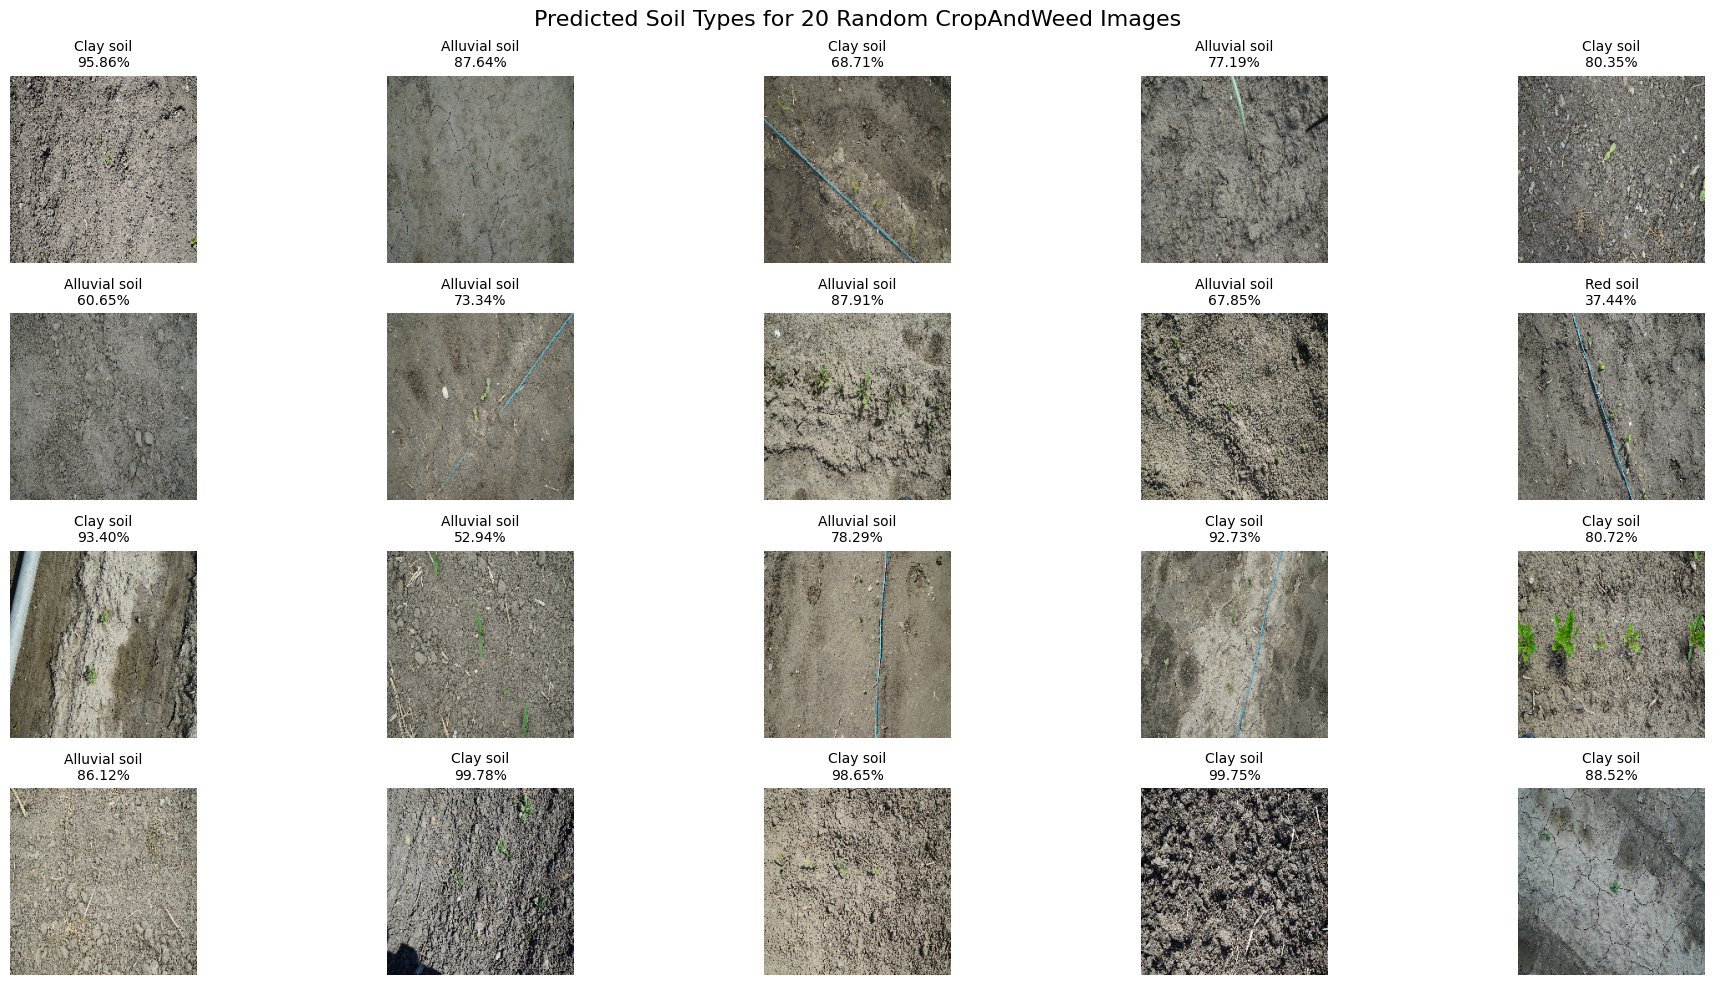

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

# === Load the trained model ===
model = load_model("best_soil_model.h5")

# === Define your class labels ===
class_labels = list(test_gen.class_indices.keys())  # E.g., ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
print(class_labels)

# === Define prediction function ===
def predict_soil(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)
    predicted_class = class_labels[np.argmax(pred)]
    confidence = float(np.max(pred))
    return predicted_class, confidence

# === Image directory ===
image_dir = "/content/drive/MyDrive/crop_and_weed/images"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(".jpg")]

# === Pick 20 random images ===
sample_images = random.sample(image_files, 20)

# === Plotting ===
plt.figure(figsize=(20, 10))

for idx, fname in enumerate(sample_images):
    img_path = os.path.join(image_dir, fname)
    label, conf = predict_soil(img_path)

    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img).astype(np.uint8)

    plt.subplot(4, 5, idx + 1)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"{label}\n{conf:.2%}", fontsize=10)
    plt.axis('off')

plt.suptitle("Predicted Soil Types for 20 Random CropAndWeed Images", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
!kaggle datasets download -d gosegomenwe/soil-data-v3

Dataset URL: https://www.kaggle.com/datasets/gosegomenwe/soil-data-v3
License(s): unknown
 93% 1.27G/1.36G [00:01<00:00, 1.17GB/s]
100% 1.36G/1.36G [00:01<00:00, 1.26GB/s]


In [ ]:
!unzip -q soil-data-v3.zip -d soil_dataset_v3

Found 3665 images belonging to 8 classes.
Found 1583 images belonging to 8 classes.
Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 625ms/step - accuracy: 0.2190 - loss: 2.0233 - val_accuracy: 0.2944 - val_loss: 1.7947
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 536ms/step - accuracy: 0.2978 - loss: 1.8151 - val_accuracy: 0.3209 - val_loss: 1.7407
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 537ms/step - accuracy: 0.3053 - loss: 1.7649 - val_accuracy: 0.3159 - val_loss: 1.7633
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 537ms/step - accuracy: 0.3247 - loss: 1.7530 - val_accuracy: 0.3253 - val_loss: 1.7141
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 541ms/step - accuracy: 0.3399 - loss: 1.7101 - val_accuracy: 0.3392 - val_loss: 1.6881


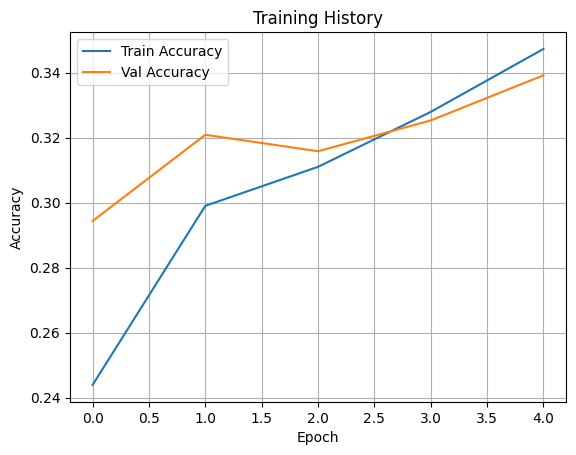

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# === Paths ===
train_dir = "/content/soil_dataset_v3/Soil_Data_V3/Trains"
test_dir = "/content/soil_dataset_v3/Soil_Data_V3/Tests"

# === Image size and batch ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# === Data Augmentation and Generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# === Build ResNet50 Model ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Train the model ===
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=test_gen
)

# === Plot training history ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# === Save model ===
model.save("/content/soil_classifier_resnet50.h5")


In [ ]:
#get rid of annoying GPU warnings (and others)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.svm import SVC
import sklearn

In [ ]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.models import Sequential, model_from_json  # Model type to be used
from keras.optimizers import Adam

from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical  # Direct import
from pathlib import Path

In [ ]:
def load_image_files(container_path, dimension=(128,128)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "Soil Capstone Dataset Training"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            if file.suffix.lower() not in ['.jpg', '.jpeg', '.png','.webp','.gif']:
                print(f"Skipped non-image file: {file}")
                continue
            img = cv2.imread(str(file), cv2.IMREAD_COLOR)
            if img is None:
                print(f"Failed to read image: {file}")
                continue
            img_resized = cv2.resize(img, dimension, interpolation=cv2.INTER_AREA)

            if img_resized.size == 0:
                print(f"Empty image: {file}")
                continue
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)


    return Bunch(
        data=flat_data,
        target=target,
        target_names=categories,
        images=images,
        DESCR=descr
    )

In [ ]:
# === Paths ===
#train_dir = "/content/soil_dataset_v3/Soil_Data_V3/Trains"
#test_dir = "/content/soil_dataset_v3/Soil_Data_V3/Tests"

image_dataset = load_image_files("/content/soil_dataset_v3/Soil_Data_V3/Trains")
image_dataset_test = load_image_files("/content/soil_dataset_v3/Soil_Data_V3/Tests")

Skipped non-image file: /content/soil_dataset_v3/Soil_Data_V3/Trains/Sand/desktop.ini
Skipped non-image file: /content/soil_dataset_v3/Soil_Data_V3/Trains/Mary/desktop.ini
Skipped non-image file: /content/soil_dataset_v3/Soil_Data_V3/Trains/Silt/desktop.ini
Skipped non-image file: /content/soil_dataset_v3/Soil_Data_V3/Tests/Chalky/desktop.ini


In [ ]:
accuracy = []
f1_score = []
precision_score = []
recall_score = []

In [ ]:
X_train = image_dataset.images.reshape(-1,128*128*3)
X_test = image_dataset_test.images.reshape(-1,128*128*3)
y_train = image_dataset.target
y_test=image_dataset_test.target

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess test dataset

test_features = X_test


# Load and preprocess train dataset

train_features = X_train


# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

# Perform PCA
pca = PCA(n_components = 200)
X_train = pca.fit_transform(scaled_train_features, y_train)
X_test = pca.transform(scaled_test_features)


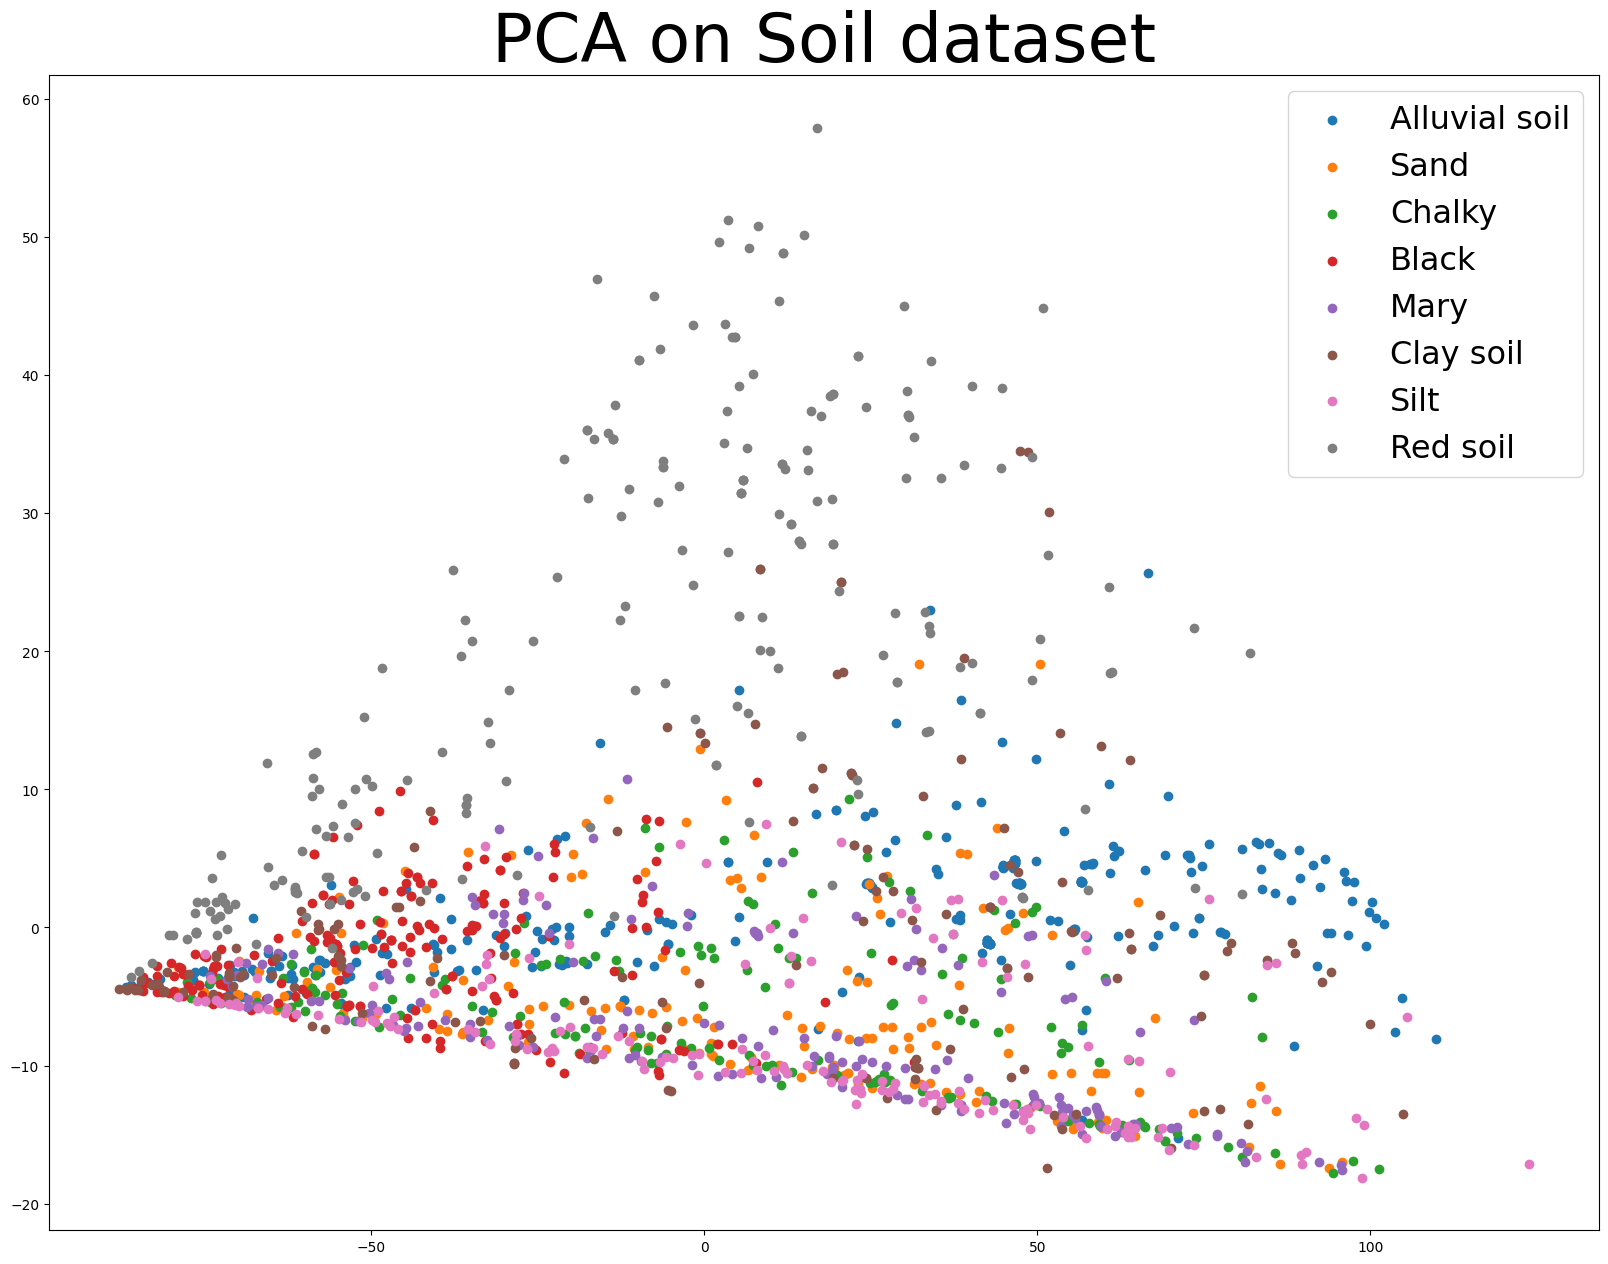

In [ ]:
plt.figure(figsize=(20,15))
for  i, target_name in zip([ 0, 1, 2, 3, 4, 5, 6, 7], image_dataset.target_names):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test== i, 1], label=target_name)
plt.legend(fontsize=23)
plt.title('PCA on Soil dataset', fontsize =49)

plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

# Start timing
start_time = time.time()
clf_rf = RandomForestClassifier(class_weight='balanced',max_depth= 9, min_samples_leaf= 3, min_samples_split= 2, random_state=42)

clf_rf.fit(X_train,y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = metrics.precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = metrics.recall_score(y_test, y_pred_rf, average='weighted')
print(metrics.classification_report(y_test, y_pred_rf, target_names=image_dataset.target_names))
print("Accuracy", round(accuracy_rf*100,2))

print("F1-score ",round(f1_rf*100,2))
print("Precision ",round(precision_rf*100,2))
print("Recall",round(recall_rf*100,2))

accuracy.append(round(accuracy_rf*100,2))
f1_score.append(round(f1_rf*100,2))


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", round(elapsed_time, 2), "seconds")

               precision    recall  f1-score   support

Alluvial soil       0.88      0.83      0.85       316
         Sand       0.84      0.57      0.68       170
       Chalky       0.71      0.73      0.72       166
        Black       0.52      0.97      0.68       210
         Mary       0.89      0.74      0.81       172
    Clay soil       0.81      0.56      0.66       160
         Silt       0.73      0.60      0.66       168
     Red soil       0.88      0.86      0.87       222

     accuracy                           0.75      1584
    macro avg       0.78      0.73      0.74      1584
 weighted avg       0.79      0.75      0.75      1584

Accuracy 75.25
F1-score  75.46
Precision  78.79
Recall 75.25
Elapsed Time: 4.07 seconds


Found 3665 images belonging to 8 classes.
Found 1583 images belonging to 8 classes.
Class weights: {0: np.float64(0.625853825136612), 1: np.float64(0.9504668049792531), 2: np.float64(1.1807345360824741), 3: np.float64(1.244904891304348), 4: np.float64(1.1568813131313131), 5: np.float64(0.8895631067961165), 6: np.float64(1.162753807106599), 7: np.float64(1.1746794871794872)}
Epoch 1/25
115/115 - 143s - 1s/step - accuracy: 0.1083 - loss: 2.1802 - val_accuracy: 0.1049 - val_loss: 2.1981
Epoch 2/25
115/115 - 69s - 600ms/step - accuracy: 0.1078 - loss: 2.1834 - val_accuracy: 0.1049 - val_loss: 2.1981
Epoch 3/25
115/115 - 69s - 598ms/step - accuracy: 0.1108 - loss: 2.1766 - val_accuracy: 0.1049 - val_loss: 2.1981
Epoch 4/25
115/115 - 69s - 601ms/step - accuracy: 0.1141 - loss: 2.1812 - val_accuracy: 0.1049 - val_loss: 2.1981
Epoch 5/25
115/115 - 69s - 600ms/step - accuracy: 0.1124 - loss: 2.1796 - val_accuracy: 0.1049 - val_loss: 2.1981
Epoch 6/25
115/115 - 69s - 601ms/step - accuracy: 0.105

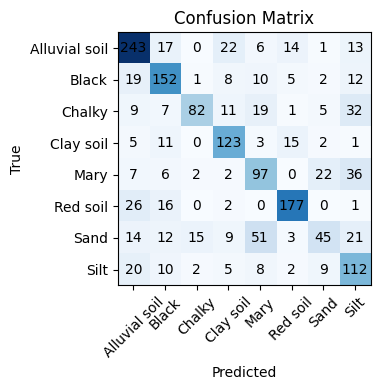

In [56]:
# ==============================================================
# Soil-Type Classifier  v2.1  –  EfficientNetB0 + One-Cycle LR
# ==============================================================

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np, matplotlib.pyplot as plt, itertools, warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- 1. Paths & basic hyper-params ----------
train_dir = "/content/soil_dataset_v3/Soil_Data_V3/Trains"
val_dir   = "/content/soil_dataset_v3/Soil_Data_V3/Tests"


IMG_SIZE     = (224, 224)
BATCH_SIZE   = 32
EPOCHS_HEAD  = 25
EPOCHS_FINE  = 12
MAX_LR       = 1e-4
N_CLASSES    = 8

# ---------- 2. Data generators ----------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=15,
    fill_mode='reflect'
).flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# ---------- 3. Class weights ----------
cw_vals = compute_class_weight('balanced',
                               classes=np.unique(train_gen.classes),
                               y=train_gen.classes)
class_weight = dict(enumerate(cw_vals))
print("Class weights:", class_weight)

# ---------- 4. Build model ----------
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet',
    input_shape=IMG_SIZE + (3,), pooling='avg'
)
base.trainable = False

inputs  = layers.Input(shape=IMG_SIZE + (3,))
x       = base(inputs, training=False)
x       = layers.Dropout(0.5)(x)
outputs = layers.Dense(N_CLASSES, activation='softmax')(x)
model   = models.Model(inputs, outputs)

# ---------- 5. Robust One-Cycle LR callback ----------
class OneCycleLR(tf.keras.callbacks.Callback):
    def __init__(self, max_lr, total_steps, min_lr=1e-5):
        super().__init__()
        self.max_lr, self.total_steps, self.min_lr = max_lr, total_steps, min_lr

    def _set_lr(self, new_lr):
        """Safely set LR whether it's a tf.Variable, tensor, float, or stray str."""
        try:
            lr_ref = self.model.optimizer.learning_rate
        except AttributeError:       # ultra-old TF
            lr_ref = self.model.optimizer.lr

        # If lr_ref is Variable / Tensor → set_value; else → assign directly
        if isinstance(lr_ref, tf.Variable):
            tf.keras.backend.set_value(lr_ref, new_lr)
        else:
            try:
                lr_ref.assign(new_lr)         # tensor?
            except Exception:
                self.model.optimizer.learning_rate = float(new_lr)

    def on_train_batch_begin(self, batch, logs=None):
        step = tf.keras.backend.get_value(self.model.optimizer.iterations)
        pct  = step / self.total_steps
        if pct <= 0.3:
            lr = self.max_lr * pct / 0.3
        else:
            rem = (pct - 0.3) / 0.7
            lr = self.min_lr + 0.5*(self.max_lr - self.min_lr)*(1 + tf.math.cos(np.pi*rem))
        self._set_lr(lr)

steps_per_epoch = int(np.ceil(len(train_gen.classes) / BATCH_SIZE))
onecycle = OneCycleLR(max_lr=MAX_LR, total_steps=steps_per_epoch * EPOCHS_HEAD)

early_stop = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)

# ---------- 6. Compile & train head ----------
model.compile(
    optimizer=tf.keras.optimizers.Adam(MAX_LR),   # **float, not string**
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_head = model.fit(
    train_gen,
    epochs=EPOCHS_HEAD,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[onecycle, early_stop],
    verbose=2
)

# ---------- 7. Fine-tune full backbone ----------
base.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=2
)

# ---------- 8. Evaluate ----------
y_true = val_gen.classes
y_pred = model.predict(val_gen, verbose=0).argmax(axis=1)

print("\n" + classification_report(
    y_true, y_pred, target_names=val_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(N_CLASSES), val_gen.class_indices.keys(), rotation=45)
plt.yticks(range(N_CLASSES), val_gen.class_indices.keys())
for i, j in itertools.product(range(N_CLASSES), range(N_CLASSES)):
    plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout(); plt.show()


In [42]:
import cv2
import numpy as np

shapes = []
for cls in class_dirs:
    folder = os.path.join(root, cls)
    sample = next(f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png')))
    h, w = cv2.imread(os.path.join(folder, sample)).shape[:2]
    shapes.append((cls, w, h, round(w / h, 2)))

pd.DataFrame(shapes, columns=["Class", "Width", "Height", "Aspect Ratio"])


NameError: name 'class_dirs' is not defined

Found 3665 images belonging to 8 classes.
Found 1583 images belonging to 8 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


115/115 - 234s - 2s/step - accuracy: 0.1119 - loss: 2.1123 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 2/15
115/115 - 105s - 911ms/step - accuracy: 0.1064 - loss: 2.1060 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 3/15
115/115 - 105s - 916ms/step - accuracy: 0.1086 - loss: 2.1131 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 4/15
115/115 - 106s - 919ms/step - accuracy: 0.1124 - loss: 2.1130 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 5/15
115/115 - 108s - 935ms/step - accuracy: 0.1121 - loss: 2.1067 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 6/15
115/115 - 104s - 909ms/step - accuracy: 0.1179 - loss: 2.1058 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 7/15
115/115 - 106s - 919ms/step - accuracy: 0.0985 - loss: 2.1190 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 8/15
115/115 - 106s - 918ms/step - accuracy: 0.1149 - loss: 2.1118 - val_accuracy: 0.1061 - val_loss: 2.1117
Epoch 9/15
115/115 - 106s - 919ms/step - accuracy: 0.1124 - loss: 2.1104 - val_accuracy: 0.106

115/115 - 399s - 3s/step - accuracy: 0.2286 - loss: 2.0116 - val_accuracy: 0.1478 - val_loss: 2.0425
Epoch 2/25
115/115 - 106s - 919ms/step - accuracy: 0.3992 - loss: 1.7694 - val_accuracy: 0.1769 - val_loss: 2.0595
Epoch 3/25


115/115 - 106s - 921ms/step - accuracy: 0.5225 - loss: 1.5542 - val_accuracy: 0.2514 - val_loss: 1.9494
Epoch 4/25


115/115 - 107s - 927ms/step - accuracy: 0.5746 - loss: 1.4194 - val_accuracy: 0.3184 - val_loss: 1.8755
Epoch 5/25


115/115 - 107s - 931ms/step - accuracy: 0.6256 - loss: 1.2842 - val_accuracy: 0.4637 - val_loss: 1.5504
Epoch 6/25


115/115 - 106s - 926ms/step - accuracy: 0.6548 - loss: 1.1858 - val_accuracy: 0.5951 - val_loss: 1.3257
Epoch 7/25


115/115 - 107s - 927ms/step - accuracy: 0.6761 - loss: 1.1238 - val_accuracy: 0.7025 - val_loss: 1.0688
Epoch 8/25


115/115 - 106s - 925ms/step - accuracy: 0.7001 - loss: 1.0577 - val_accuracy: 0.7631 - val_loss: 0.9393
Epoch 9/25


115/115 - 107s - 928ms/step - accuracy: 0.7187 - loss: 1.0157 - val_accuracy: 0.7562 - val_loss: 0.9332
Epoch 10/25
115/115 - 106s - 921ms/step - accuracy: 0.7326 - loss: 0.9808 - val_accuracy: 0.7461 - val_loss: 0.9436
Epoch 11/25


115/115 - 107s - 931ms/step - accuracy: 0.7566 - loss: 0.9366 - val_accuracy: 0.7707 - val_loss: 0.8667
Epoch 12/25


115/115 - 107s - 928ms/step - accuracy: 0.7632 - loss: 0.9045 - val_accuracy: 0.8162 - val_loss: 0.7914
Epoch 13/25
115/115 - 105s - 912ms/step - accuracy: 0.7678 - loss: 0.8807 - val_accuracy: 0.8149 - val_loss: 0.7997
Epoch 14/25


115/115 - 107s - 933ms/step - accuracy: 0.7885 - loss: 0.8378 - val_accuracy: 0.8149 - val_loss: 0.7842
Epoch 15/25


115/115 - 107s - 930ms/step - accuracy: 0.7935 - loss: 0.8225 - val_accuracy: 0.8219 - val_loss: 0.7724
Epoch 16/25
115/115 - 105s - 915ms/step - accuracy: 0.8055 - loss: 0.8080 - val_accuracy: 0.7871 - val_loss: 0.8580
Epoch 17/25
115/115 - 106s - 918ms/step - accuracy: 0.8109 - loss: 0.7733 - val_accuracy: 0.7783 - val_loss: 0.8461
Epoch 18/25


115/115 - 107s - 931ms/step - accuracy: 0.8262 - loss: 0.7560 - val_accuracy: 0.8282 - val_loss: 0.7214
Epoch 19/25


115/115 - 107s - 932ms/step - accuracy: 0.8270 - loss: 0.7302 - val_accuracy: 0.8402 - val_loss: 0.7071
Epoch 20/25


115/115 - 107s - 930ms/step - accuracy: 0.8325 - loss: 0.7154 - val_accuracy: 0.8654 - val_loss: 0.6387
Epoch 21/25
115/115 - 105s - 915ms/step - accuracy: 0.8396 - loss: 0.7112 - val_accuracy: 0.8471 - val_loss: 0.6848
Epoch 22/25
115/115 - 106s - 921ms/step - accuracy: 0.8494 - loss: 0.6854 - val_accuracy: 0.8250 - val_loss: 0.7315
Epoch 23/25
115/115 - 105s - 913ms/step - accuracy: 0.8434 - loss: 0.6878 - val_accuracy: 0.8143 - val_loss: 0.7557
Epoch 24/25


115/115 - 107s - 929ms/step - accuracy: 0.8491 - loss: 0.6638 - val_accuracy: 0.8812 - val_loss: 0.5942
Epoch 25/25
115/115 - 105s - 915ms/step - accuracy: 0.8505 - loss: 0.6627 - val_accuracy: 0.8515 - val_loss: 0.6613
               precision    recall  f1-score   support

Alluvial soil       0.95      0.84      0.89       316
        Black       0.84      0.92      0.88       209
       Chalky       0.82      0.87      0.84       166
    Clay soil       0.88      0.92      0.90       160
         Mary       0.89      0.93      0.91       172
     Red soil       0.88      0.94      0.91       222
         Sand       0.91      0.79      0.84       170
         Silt       0.87      0.86      0.86       168

     accuracy                           0.88      1583
    macro avg       0.88      0.88      0.88      1583
 weighted avg       0.88      0.88      0.88      1583



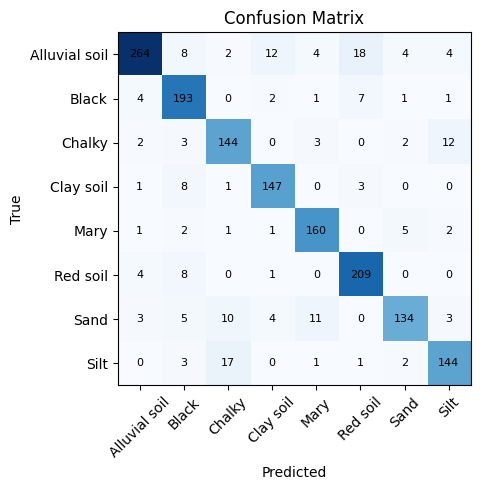

In [40]:
# ==============================================================
# Soil-Type Classifier  v3.2
# EfficientNetB3  +  Label-Smoothing  +  One-Cycle LR  (mixed-precision safe)
# ==============================================================

import os, math, warnings, itertools, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore", category=UserWarning)

# --------------------------------------------------------------
# 0️⃣  Mixed-precision (keeps model fast & memory-efficient)
# --------------------------------------------------------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# --------------------------------------------------------------
# 1️⃣  Paths & hyper-params  (⟵ edit these two)
# --------------------------------------------------------------

# ---------- 1. Paths & basic hyper-params ----------
train_dir = "/content/soil_dataset_v3/Soil_Data_V3/Trains"
val_dir   = "/content/soil_dataset_v3/Soil_Data_V3/Tests"


IMG_SIZE         = (300, 300)
BATCH_SIZE       = 32          # bigger batch now, thanks to FP16
EPOCHS_HEAD      = 15
EPOCHS_FINE      = 25
MAX_LR           = 3e-4
N_CLASSES        = 8
SEED             = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# --------------------------------------------------------------
# 2️⃣  Data generators
# --------------------------------------------------------------
train_datagen = ImageDataGenerator(
    rescale            = 1./255,
    rotation_range     = 40,
    width_shift_range  = 0.25,
    height_shift_range = 0.25,
    zoom_range         = 0.35,
    horizontal_flip    = True,
    vertical_flip      = True,
    brightness_range   = [0.6, 1.4],
    shear_range        = 20,
    fill_mode          = 'reflect'
)
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', seed=SEED
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# --------------------------------------------------------------
# 3️⃣  Class weights
# --------------------------------------------------------------
cw_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight = dict(enumerate(cw_vals))

# --------------------------------------------------------------
# 4️⃣  Build model
# --------------------------------------------------------------
base = tf.keras.applications.EfficientNetB3(
    include_top=False, weights='imagenet',
    input_shape=IMG_SIZE + (3,), pooling='avg'
)
base.trainable = False    # freeze for head-training

inp  = layers.Input(shape=IMG_SIZE + (3,))
x    = base(inp, training=False)
x    = layers.Dropout(0.4)(x)
out  = layers.Dense(N_CLASSES, activation='softmax', dtype='float32')(x)
model = models.Model(inp, out)

# --------------------------------------------------------------
# 5️⃣  One-Cycle LR  (mixed-precision-safe)
# --------------------------------------------------------------
class OneCycleLR(tf.keras.callbacks.Callback):
    def __init__(self, max_lr, total_steps, min_lr=1e-6):
        super().__init__()
        self.max_lr = max_lr; self.total_steps = total_steps; self.min_lr = min_lr
    def _set_lr(self, lr):
        opt = self.model.optimizer
        if hasattr(opt, "inner_optimizer"):  # unwrap LossScaleOptimizer
            opt = opt.inner_optimizer
        lr_var = getattr(opt, "learning_rate", None)
        if lr_var is None:
            lr_var = getattr(opt, "lr", None)
        if isinstance(lr_var, tf.Variable):
            tf.keras.backend.set_value(lr_var, lr)
        else:
            try:    lr_var.assign(lr)
            except: opt.learning_rate = float(lr)
    def on_train_batch_begin(self, batch, logs=None):
        step = tf.keras.backend.get_value(self.model.optimizer.iterations)
        pct  = step / self.total_steps
        if pct <= 0.3:         lr = self.max_lr * pct / 0.3            # warm-up
        else:                  lr = self.min_lr + 0.5*(self.max_lr-self.min_lr)*(
                                             1 + tf.math.cos(math.pi*(pct-0.3)/0.7))
        self._set_lr(lr)

steps_per_epoch = math.ceil(train_gen.samples / BATCH_SIZE)
onecycle   = OneCycleLR(MAX_LR, steps_per_epoch * EPOCHS_HEAD)
early_stop = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
ckpt       = tf.keras.callbacks.ModelCheckpoint("best_soil_b3_v3_2.h5", save_best_only=True)

# --------------------------------------------------------------
# 6️⃣  Compile & train head  (label-smoothing CE)
# --------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(MAX_LR),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

history_head = model.fit(
    train_gen,
    epochs=EPOCHS_HEAD,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[onecycle, early_stop, ckpt],
    verbose=2
)

# --------------------------------------------------------------
# 7️⃣  Fine-tune ALL layers  (low LR)
# --------------------------------------------------------------
base.trainable = True   # unfreeze everything
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[early_stop, ckpt],
    verbose=2
)

# --------------------------------------------------------------
# 8️⃣  Test-time augmentation (TTA) + evaluation
# --------------------------------------------------------------
def predict_tta(generator, passes=5):
    preds = np.zeros((generator.samples, N_CLASSES))
    for _ in range(passes):
        generator.reset()
        preds += model.predict(generator, verbose=0)
    return preds / passes

y_true = val_gen.classes
y_pred = predict_tta(val_gen, passes=7).argmax(axis=1)

print(classification_report(
    y_true, y_pred,
    target_names=val_gen.class_indices.keys(), digits=2
))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(N_CLASSES), val_gen.class_indices.keys(), rotation=45)
plt.yticks(range(N_CLASSES), val_gen.class_indices.keys())
for i, j in itertools.product(range(N_CLASSES), range(N_CLASSES)):
    plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=8)
plt.tight_layout(); plt.show()


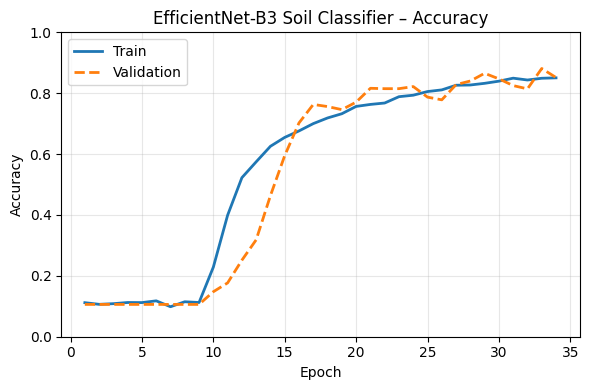

Saved ➜ soil_train_val_accuracy.png


In [55]:
import matplotlib.pyplot as plt
import numpy as np

# ──────────────────────────────────────────────────────────────
# 1️⃣  Concatenate metrics from both phases
# ──────────────────────────────────────────────────────────────
def combine_histories(hist1, hist2, metric):
    vals1 = hist1.history.get(metric, [])
    vals2 = hist2.history.get(metric, [])
    return np.concatenate([vals1, vals2])

acc      = combine_histories(history_head, history_fine, "accuracy")
val_acc  = combine_histories(history_head, history_fine, "val_accuracy")
epochs   = range(1, len(acc) + 1)

# ──────────────────────────────────────────────────────────────
# 2️⃣  Plot
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 4))
plt.plot(epochs, acc,      label="Train",        linewidth=2)
plt.plot(epochs, val_acc,  label="Validation",   linestyle="--", linewidth=2)

plt.title("EfficientNet-B3 Soil Classifier – Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# ──────────────────────────────────────────────────────────────
# 3️⃣  Save high-resolution image
# ──────────────────────────────────────────────────────────────
plt.savefig("soil_train_val_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved ➜ soil_train_val_accuracy.png")


Train  Test
Class                     
Alluvial soil    732   316
Black            482   209
Chalky           388   166
Clay soil        368   160
Mary             396   172
Red soil         515   222
Sand             394   170
Silt             390   168

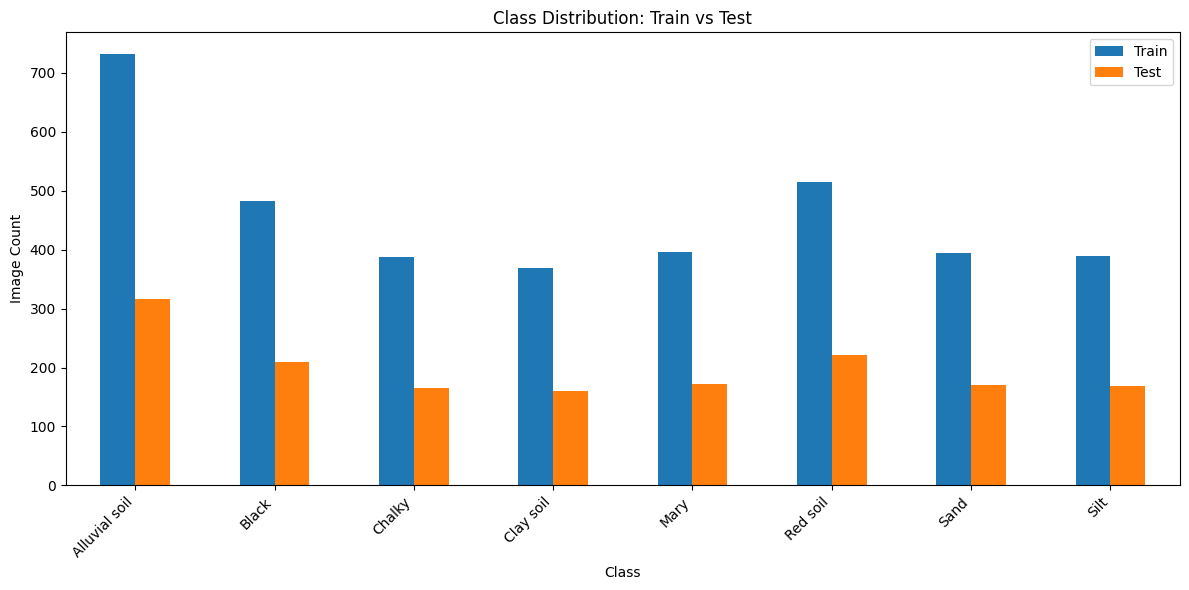

In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt

train_dir = "/content/soil_dataset_v3/Soil_Data_V3/Trains"
val_dir   = "/content/soil_dataset_v3/Soil_Data_V3/Tests"

def get_class_distribution(path):
    return {
        cls: len([
            f for f in os.listdir(os.path.join(path, cls))
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        for cls in sorted(os.listdir(path)) if os.path.isdir(os.path.join(path, cls))
    }

train_counts = get_class_distribution(train_dir)
val_counts   = get_class_distribution(val_dir)

df = pd.DataFrame({
    'Class': train_counts.keys(),
    'Train': train_counts.values(),
    'Test': [val_counts.get(cls, 0) for cls in train_counts.keys()]
})
df.set_index("Class", inplace=True)
display(df)

# 📊 Bar chart
df.plot(kind='bar', figsize=(12, 6), title="Class Distribution: Train vs Test")
plt.ylabel("Image Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [44]:
import cv2
from collections import defaultdict

def get_image_shapes(root_dir, sample_per_class=5):
    shapes = defaultdict(list)
    for cls in os.listdir(root_dir):
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for img_name in images[:sample_per_class]:
            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                shapes[cls].append((w, h))
    return shapes

shape_summary = get_image_shapes(train_dir)

print("Sample Image Sizes:")
for cls, dims in shape_summary.items():
    widths, heights = zip(*dims)
    print(f"{cls:15} → Avg Size: {np.mean(widths):.0f}×{np.mean(heights):.0f}, Aspect Ratio: {np.mean(np.array(widths)/np.array(heights)):.2f}")


Sample Image Sizes:
Alluvial soil   → Avg Size: 766×466, Aspect Ratio: 1.65
Sand            → Avg Size: 384×384, Aspect Ratio: 1.00
Chalky          → Avg Size: 416×416, Aspect Ratio: 1.00
Black           → Avg Size: 250×204, Aspect Ratio: 1.25
Mary            → Avg Size: 416×416, Aspect Ratio: 1.00
Clay soil       → Avg Size: 806×482, Aspect Ratio: 1.59
Silt            → Avg Size: 416×416, Aspect Ratio: 1.00
Red soil        → Avg Size: 403×444, Aspect Ratio: 0.89


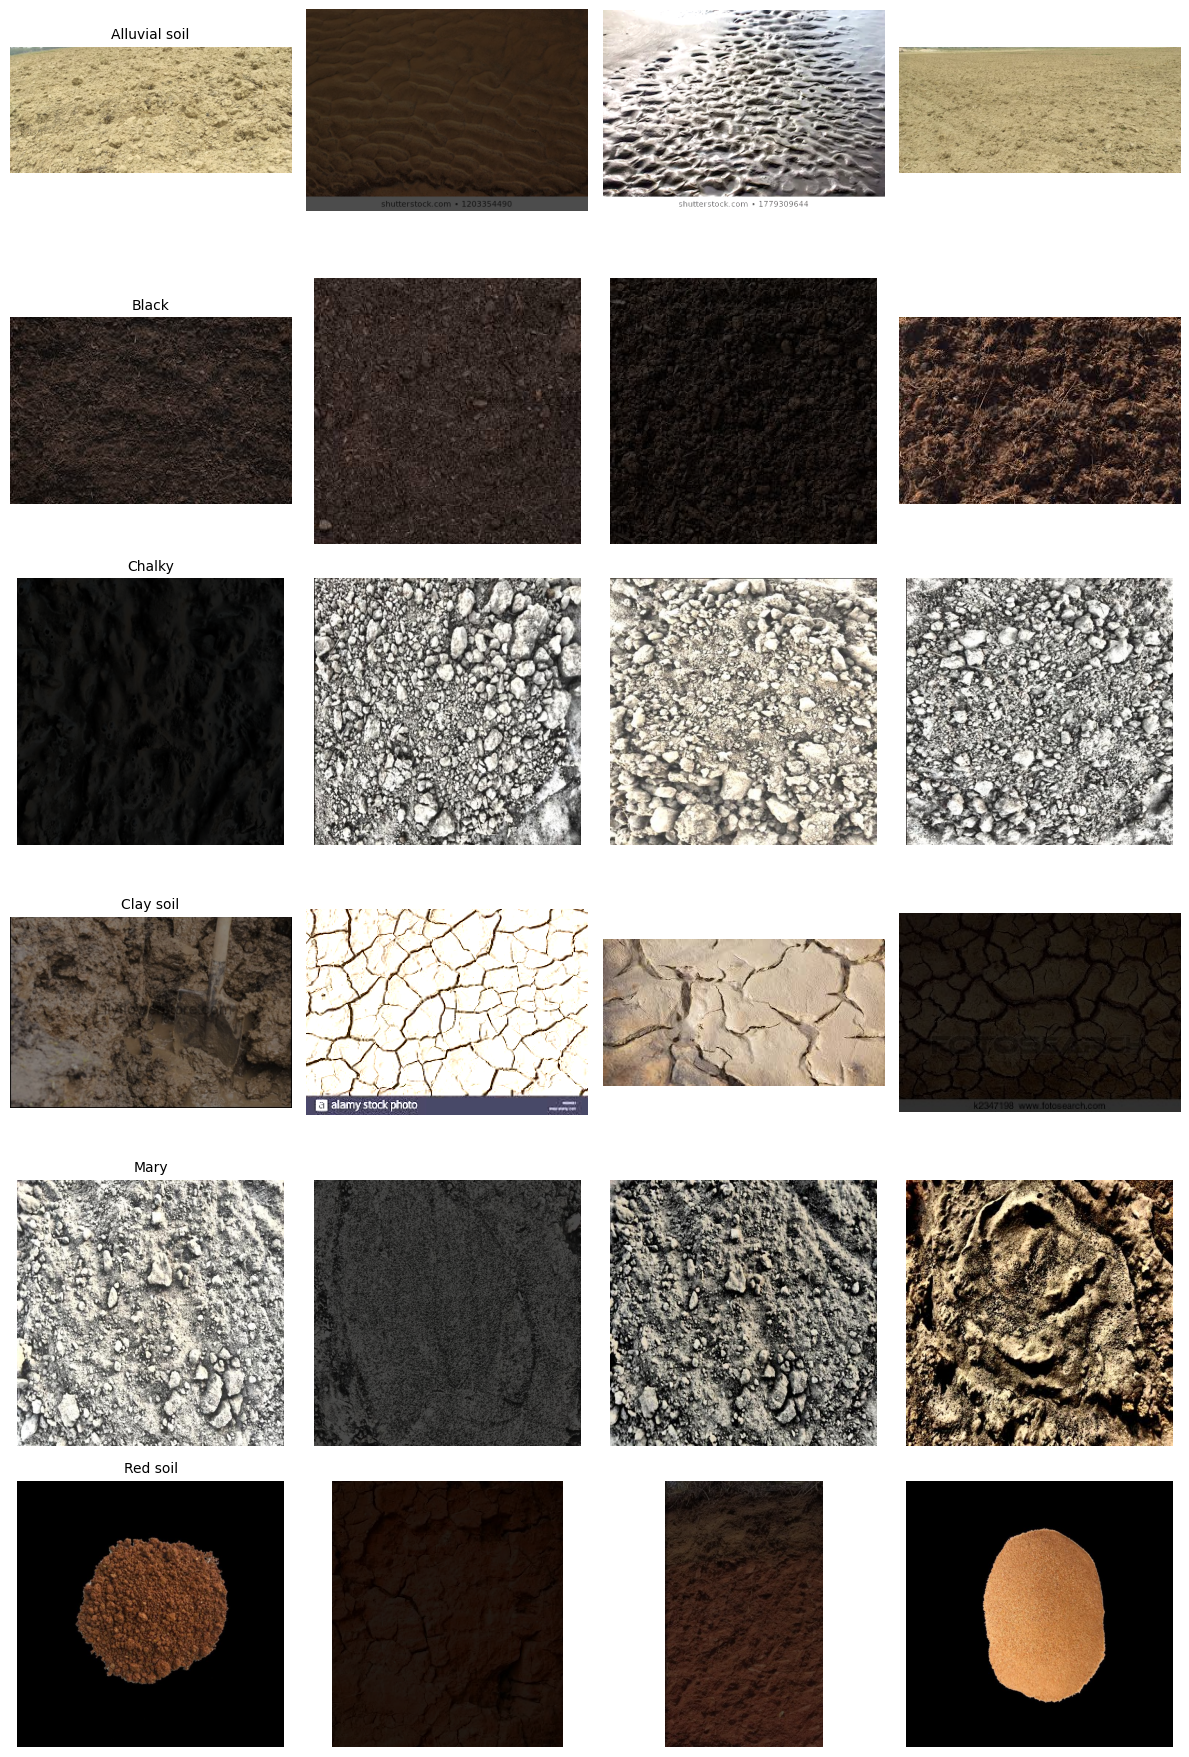

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image_grid(directory, num_classes=4, num_images=4):
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])[:num_classes]

    fig, axes = plt.subplots(num_classes, num_images, figsize=(num_images * 3, num_classes * 3))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_images]
        for j, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls, fontsize=10)
    plt.tight_layout()
    plt.show()

show_image_grid(train_dir, num_classes=6, num_images=4)


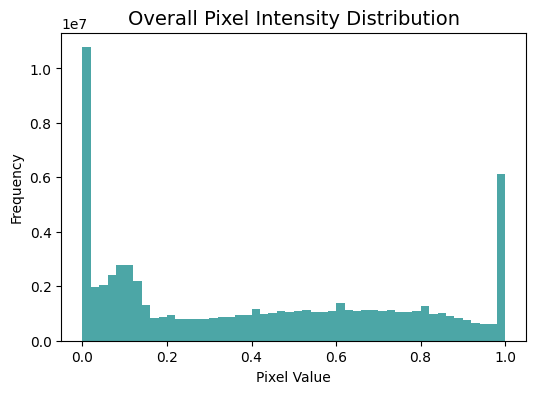

In [50]:
import random
import numpy as np

def get_color_distribution(base_dir, sample_size=100):
    paths = []
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            paths.extend([
                os.path.join(cls_path, f)
                for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
    sampled_paths = random.sample(paths, min(len(paths), sample_size))
    pixels = np.vstack([
        cv2.imread(p).reshape(-1, 3) for p in sampled_paths if cv2.imread(p) is not None
    ]).astype(np.float32) / 255.0
    return pixels

pixels = get_color_distribution(train_dir)

plt.figure(figsize=(6,4))
plt.hist(pixels.ravel(), bins=50, color='teal', alpha=0.7)
plt.title("Overall Pixel Intensity Distribution", fontsize=14)
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


In [52]:
import os, matplotlib.pyplot as plt, matplotlib.image as mpimg

# ── CONFIG ───────────────────────────────────────────────────
train_dir      = "/content/soil_dataset_v3/Soil_Data_V3/Trains"
rows_per_grid  = 5          # ↓ number of soil classes to display
cols_per_grid  = 5          # → images per class
thumb_size     = 1.2        # each cell ≈ thumb_size×thumb_size inches
out_path       = "soil_grid.png"
dpi            = 300        # higher DPI → crisper in Word
# ──────────────────────────────────────────────────────────────

classes = sorted([d for d in os.listdir(train_dir)
                  if os.path.isdir(os.path.join(train_dir, d))])[:rows_per_grid]

fig_w = cols_per_grid * thumb_size
fig_h = rows_per_grid * thumb_size
fig, axes = plt.subplots(rows_per_grid, cols_per_grid,
                         figsize=(fig_w, fig_h))

for r, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    images   = [f for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:cols_per_grid]
    for c in range(cols_per_grid):
        ax = axes[r, c]
        ax.axis('off')
        if c < len(images):
            img = mpimg.imread(os.path.join(cls_path, images[c]))
            ax.imshow(img)
        # Write class name only once (leftmost cell)
        if c == 0:
            ax.set_title(cls, fontsize=10, pad=4)

plt.tight_layout(pad=0.2)
plt.savefig(out_path, dpi=dpi, bbox_inches='tight')
plt.close(fig)         # free up memory
print(f"Saved ➜ {out_path}")


Saved ➜ soil_grid.png
